# Churn Prediction
Here we will use churn prediction from Kaggle datasets to demonstrate exploratory data analysis (EDA) on different classifiers, visualization, and how to compare models. The dataset can be found [here](https://www.kaggle.com/radmirzosimov/telecom-users-dataset).

Will be using [H2O.ai](https://www.h2o.ai) classifiers, sklearn, XGBoost, LGBMClassifier, SVC, and KNNClassifer. We will look at the performance and results from identical estimators from different pacakges.

This notebook is combination of methods and plotting from 
* [Gokul](https://www.kaggle.com/gokulrajkmv/predict-which-customer-will-leave-eda-modeling)
* [Chris](https://www.kaggle.com/docxian/telecom-customer-churn)
* [Dimtry](https://www.kaggle.com/dmitryuarov/customer-churn-eda-prediction)

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from statsmodels.graphics.mosaicplot import mosaic

import h2o
from h2o.estimators import H2ORandomForestEstimator, H2OXGBoostEstimator, H2OGradientBoostingEstimator, H2ONaiveBayesEstimator

from IPython.core.display import display, HTML, Javascript

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE

import eli5
from eli5.sklearn import PermutationImportance

from plotly.offline import download_plotlyjs, init_notebook_mode
init_notebook_mode(connected=True)

import xgboost as xgb

from lightgbm import LGBMClassifier

from typing import List

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# Load
Load the data and drop `customerID` since it is not needed for this problem.

In [2]:
df = pd.read_csv('telecom_users.csv', index_col=0)
df = df.reset_index(drop=True)
df = df.drop("customerID", axis=1)

In [3]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,Female,0,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
2,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,Male,0,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
4,Male,0,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5986 non-null   object 
 1   SeniorCitizen     5986 non-null   int64  
 2   Partner           5986 non-null   object 
 3   Dependents        5986 non-null   object 
 4   tenure            5986 non-null   int64  
 5   PhoneService      5986 non-null   object 
 6   MultipleLines     5986 non-null   object 
 7   InternetService   5986 non-null   object 
 8   OnlineSecurity    5986 non-null   object 
 9   OnlineBackup      5986 non-null   object 
 10  DeviceProtection  5986 non-null   object 
 11  TechSupport       5986 non-null   object 
 12  StreamingTV       5986 non-null   object 
 13  StreamingMovies   5986 non-null   object 
 14  Contract          5986 non-null   object 
 15  PaperlessBilling  5986 non-null   object 
 16  PaymentMethod     5986 non-null   object 


In [5]:
df.SeniorCitizen = df.SeniorCitizen.astype('object')

In [6]:
churn = df.groupby('Churn').agg({'Churn': 'count'}).rename(columns = {'Churn': 'count'}).reset_index()
churn

,Churn,count
0,No,4399
1,Yes,1587


In our data, we an imbalance of with `4399` customers who did not churn, or leave, and only `1587` who did leave.

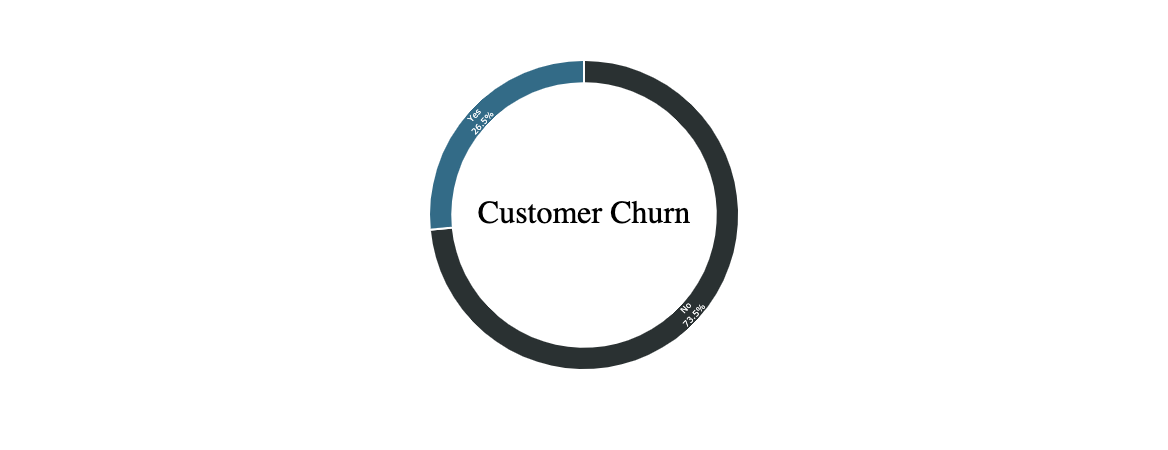

In [7]:
fig = px.pie(churn, values=churn['count'], names=churn['Churn'])
fig.update_traces(textposition='inside', 
                  textinfo='percent + label', 
                  hole=0.85, 
                  marker=dict(colors=['#2A3132','#336B87'], line=dict(color='white', width=2))
                 )

fig.update_layout(title_text='Customer Churn',
                  title_x=0.5, 
                  title_y=0.53, 
                  title_font_size=32, 
                  title_font_family='Calibri', 
                  title_font_color='black',
                  showlegend=False
                 )
                  
fig.show()

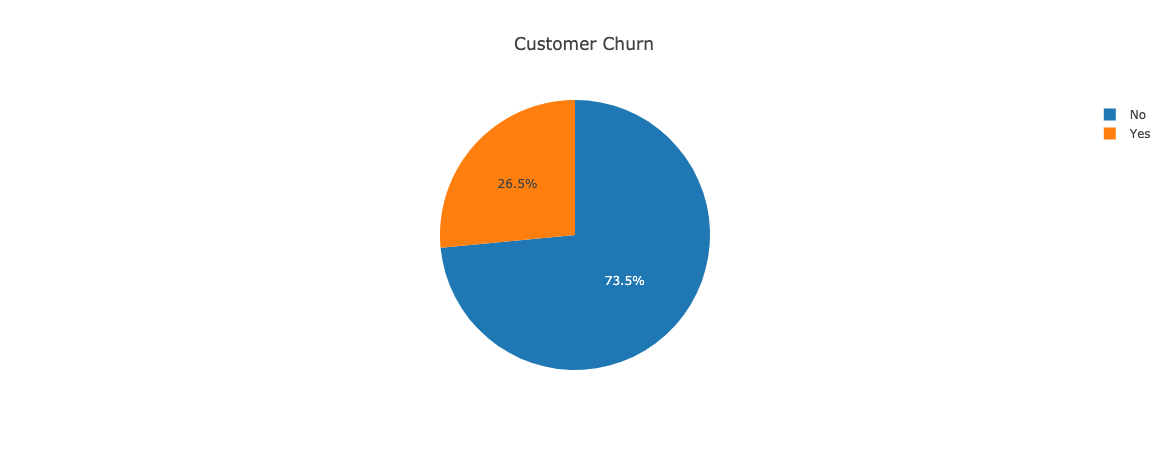

In [8]:
fig = px.pie(
    churn,
    values ='count',
    names='Churn',
    title='Customer Churn',
    template='none'
)
fig.show()

# Data Analysis
Here we will take a look at our data and see what information we can gleam about the columns.

In [9]:
cat_columns = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents',
    'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
    'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
    'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
    'Churn'
]
num_columns = ['TotalCharges', 'MonthlyCharges', 'tenure']

## Examine Numerical Columns
We see that TotalCharges has an empty string for missing value from the results as well as tenure of 0 months. For both, we have 10 instances. In many industrialized nations, we have 7-14 days to change our mind on purchases without penalty. If someone wants to leave in this time frame, would this even be a churn? It would essentially be rolled back like they did not sign up.

Is 0 months, null data or representing this case I presribed above? If someone does churn after this period, they usually most pay the month and penalties. That is, should this really be 1?

In [10]:
for feature in num_columns:
    print('*******', 'Column name:', feature, '*******')
    
    print('Min values:', df[feature].min())
    print('Max values:', df[feature].max())
    
    print('***********-end-***********')
    print('\n')

******* Column name: TotalCharges *******
Min values:  
Max values: 999.9
***********-end-***********


******* Column name: MonthlyCharges *******
Min values: 18.25
Max values: 118.75
***********-end-***********


******* Column name: tenure *******
Min values: 0
Max values: 72
***********-end-***********




## Examine Categorical Columns

In [11]:
for feature in cat_columns:
    print('\n ')
    print('*************', 'Column name:', feature, '*************')
    print('1. Unique vlaues:', df[feature].unique())
    print('\r')
    print('2. Min values:', df[feature].min())
    print('\r')
    print('3. value counts:\n', df[feature].value_counts(1) * 100)
    print('**************************************************')
    print('***************-end-******************************')
    print('\n ')


 
************* Column name: gender *************
1. Unique vlaues: ['Male' 'Female']

2. Min values: Female

3. value counts:
 Male      50.952222
Female    49.047778
Name: gender, dtype: float64
**************************************************
***************-end-******************************

 

 
************* Column name: SeniorCitizen *************
1. Unique vlaues: [0 1]

2. Min values: 0

3. value counts:
 0    83.862345
1    16.137655
Name: SeniorCitizen, dtype: float64
**************************************************
***************-end-******************************

 

 
************* Column name: Partner *************
1. Unique vlaues: ['Yes' 'No']

2. Min values: No

3. value counts:
 No     51.486803
Yes    48.513197
Name: Partner, dtype: float64
**************************************************
***************-end-******************************

 

 
************* Column name: Dependents *************
1. Unique vlaues: ['Yes' 'No']

2. Min values: No

3. value co

# Missing or Null Values (Numerical)
There a few values defined by an empty string. We will look at results using two methods to handling the values for TotalCharges.
* Assigning the values to 0
* Assigning the values to the the median

In the case of tenure, will take two approaches:
* Assigning the values to 1
* Assigning the values to the median 

For tenure, this is due to the reason described above.

The average could also be used but here this is what we will demonstrate.

In [12]:
df_med = df.copy(deep=True)
df_zero = df.copy(deep=True)

In [13]:
# empty strings converted to np.NaN
df_zero.TotalCharges = pd.to_numeric(df_zero.TotalCharges, errors='coerce')

# np.NaN -> 0
df_zero.TotalCharges = df_zero.TotalCharges.fillna(0)

# ' ' -> median
med = df_med[df_med.TotalCharges != ' ']['TotalCharges'].median()
df_med.TotalCharges =  df_med.TotalCharges.replace(' ', med)
df_med.TotalCharges = df_med['TotalCharges'].astype(float)

In [14]:
df_zero_one = df_zero.copy(deep=True)
df_zero_med = df_zero.copy(deep=True)
df_med_one = df_med.copy(deep=True)
df_med_med = df_med.copy(deep=True)

In [15]:
# 0 -> 1
df_zero_one.tenure = df_zero_one.tenure.replace(0, 1)
df_med_one.tenure = df_med_one.tenure.replace(0, 1)

# 0 -> median
med_tenure = df[df.tenure != 0]['tenure'].median()
df_zero_med.tenure = df_zero_one.tenure.replace(0, med_tenure)
df_med_med.tenure = df_med_one.tenure.replace(0, med_tenure)

In [16]:
def kdePlots(df: pd.DataFrame) -> None:
    fig = plt.figure(figsize = (17, 20))

    plt.subplot(221)
    sns.set_style("dark")
    sns.kdeplot(df.query('Churn == "Yes"')['tenure'], color='#2A3132', shade=True, label='Client left', alpha=0.5)
    sns.kdeplot(df.query('Churn == "No"')['tenure'], color='#336B87', shade=True, label='Client stayed', alpha=0.5)
    plt.ylabel('')
    plt.xlabel('Months of Use')
    plt.yticks([])
    plt.legend()

    plt.subplot(223)
    sns.set_style("dark")
    sns.kdeplot(df.query('Churn == "Yes"')['MonthlyCharges'], color='#2A3132', shade= True, label='Client left', alpha=0.5)
    sns.kdeplot(df.query('Churn == "No"')['MonthlyCharges'], color='#336B87', shade=True, label='Client stayed', alpha=0.5)
    plt.ylabel('')
    plt.xlabel('Monthly Charges')
    plt.yticks([])
    plt.legend()

    plt.subplot(224)
    sns.set_style("dark")
    sns.kdeplot(df.query('Churn == "Yes"')['TotalCharges'], color='#2A3132', shade=True, label='Client left', alpha=0.5)
    sns.kdeplot(df.query('Churn == "No"')['TotalCharges'], color='#336B87', shade=True, label='Client stayed', alpha=0.5)
    plt.ylabel('')
    plt.xlabel('Total Charges')
    plt.yticks([])
    plt.legend()


    plt.show()

In [17]:
def scatterPairWise(df: pd.DataFrame) -> None:
    sns.pairplot(df[num_columns], 
             kind='reg', 
             plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.05}})
    plt.show()

# Assigned to Zero
### Data
In this dataset, we have TotalCharges missing values assigned to zero and tenure of 0 assigned to 1.

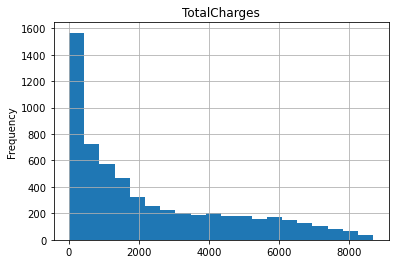

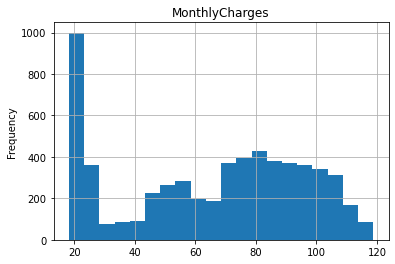

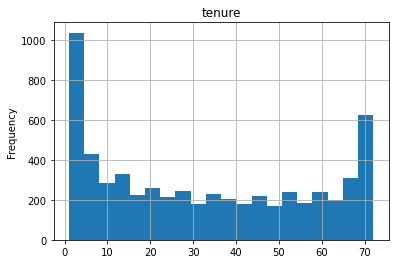

In [18]:
# Minimum tenure of 1
for col in num_columns:
    df_zero_one[col].plot(kind='hist', bins=20)
    plt.title(col)
    plt.grid()
    plt.show()

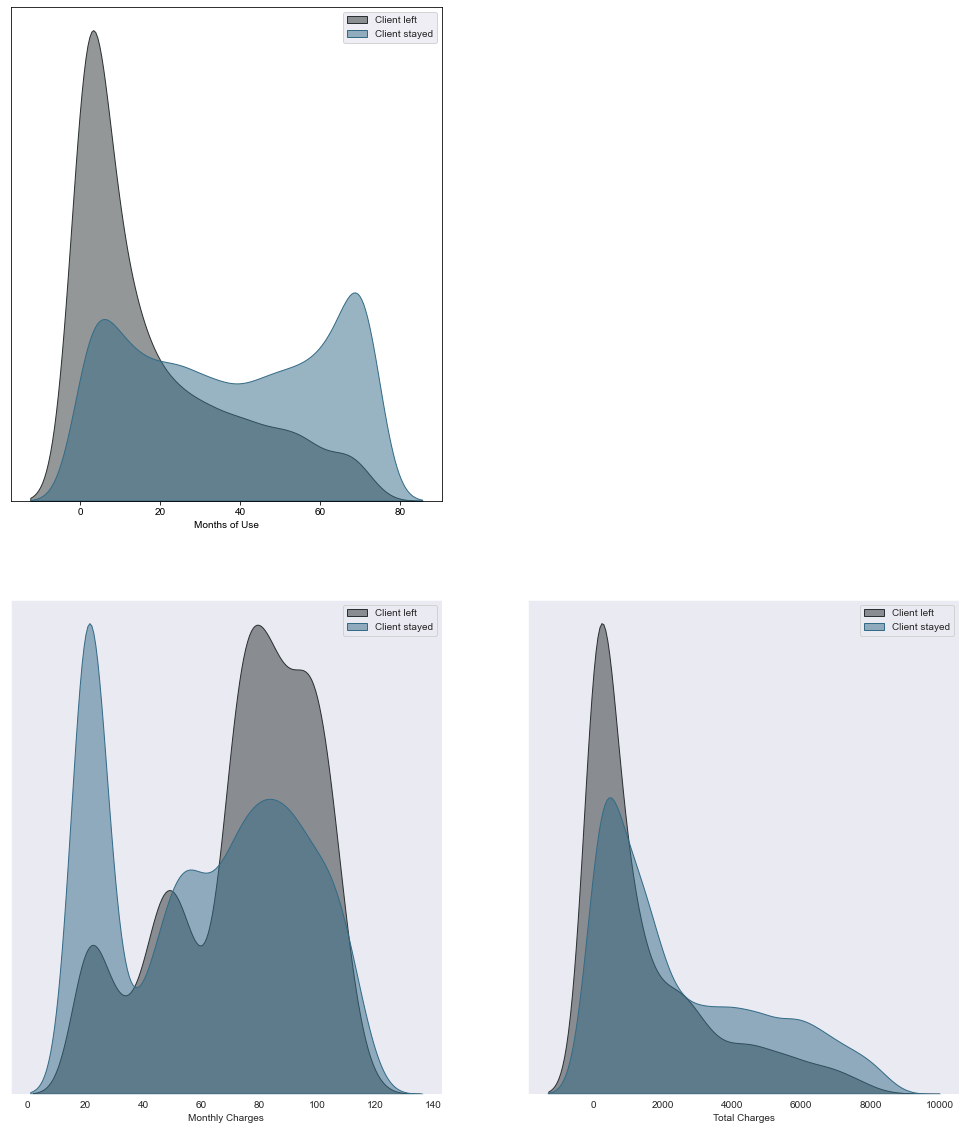

In [19]:
# Tenure 0 -> 1
kdePlots(df_zero_one)

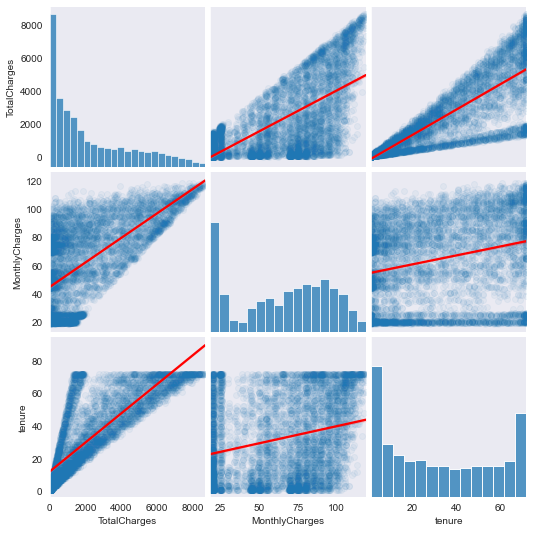

In [20]:
scatterPairWise(df_zero_one)

### Data
In this dataset, we have TotalCharges missing values assigned to zero and tenure of 0 assigned to the median.

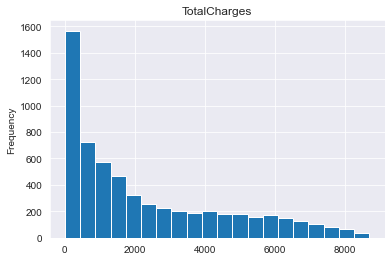

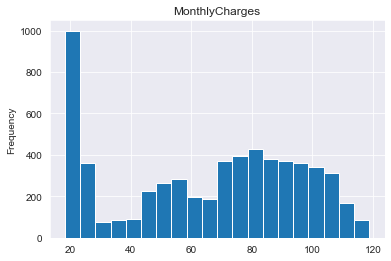

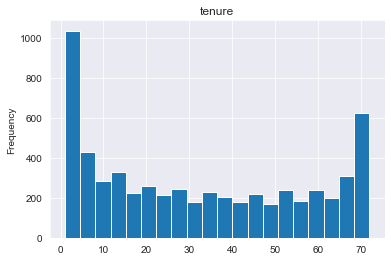

In [21]:
# Tenure of 0 mapped to median
for col in num_columns:
    df_zero_med[col].plot(kind='hist', bins=20)
    plt.title(col)
    plt.grid()
    plt.show()

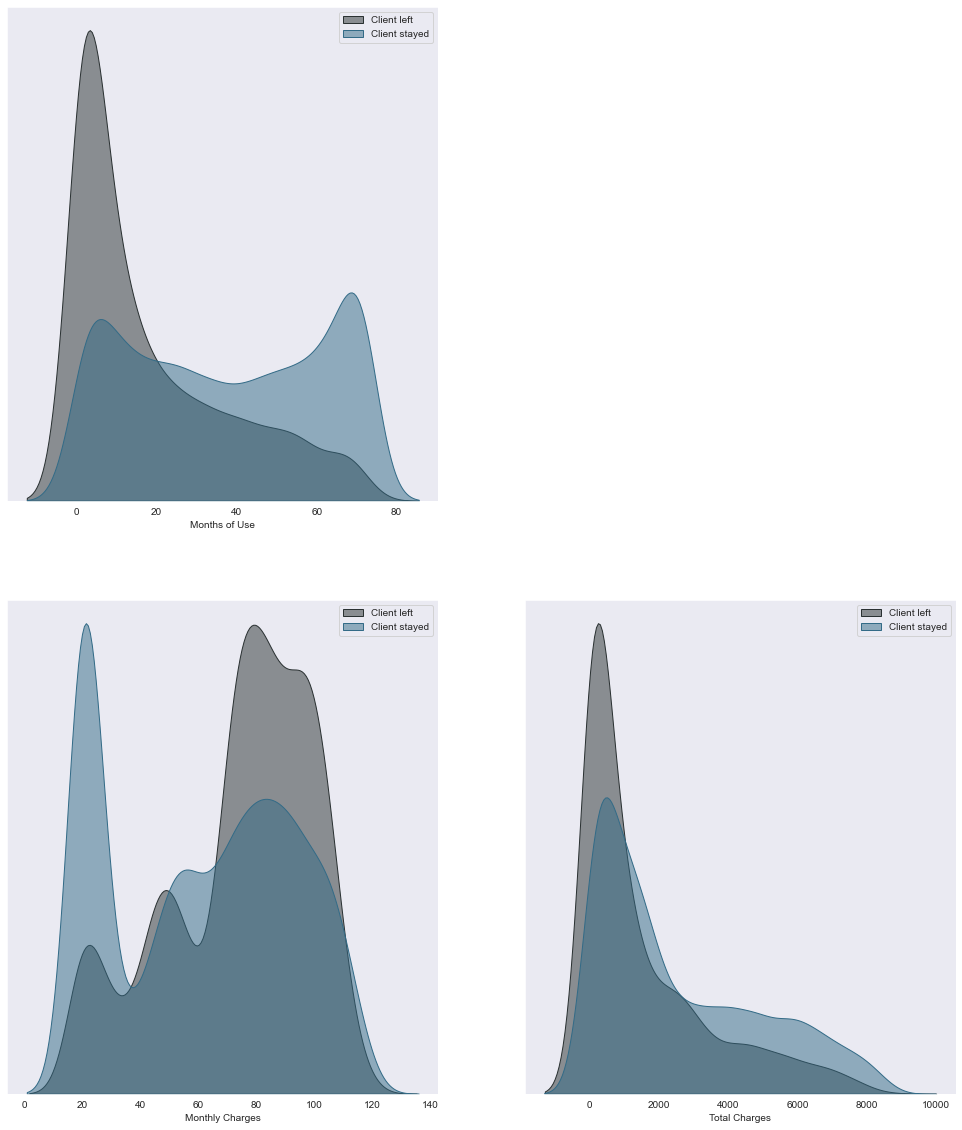

In [22]:
# Tenure 0 -> median
kdePlots(df_zero_med)

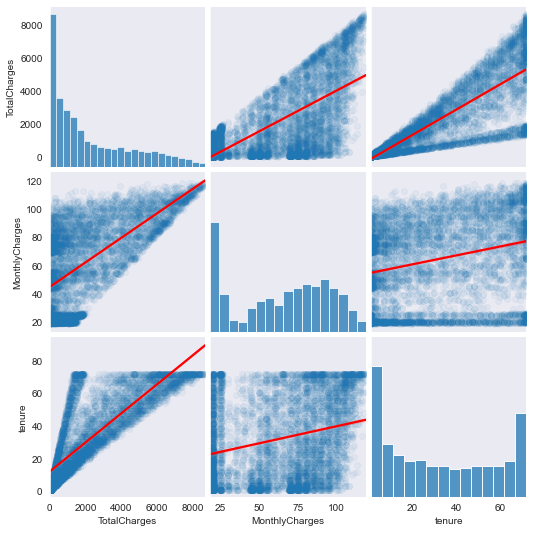

In [23]:
scatterPairWise(df_zero_med)

# Assigned to Median
### Data
In this dataset, we have TotalCharges missing values assigned to the median and tenure of 0 assigned to 1.

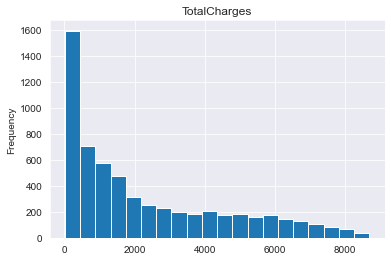

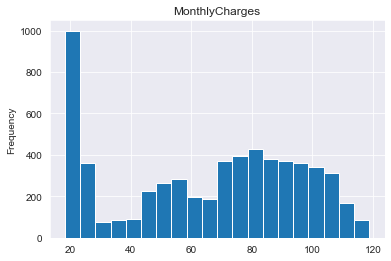

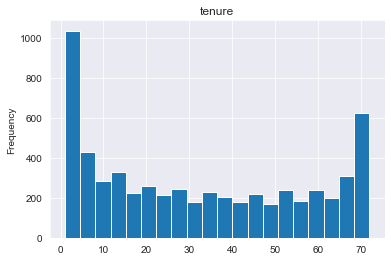

In [24]:
# Tenure 0 -> 1
for col in num_columns:
    df_med_one[col].plot(kind='hist', bins=20)
    plt.title(col)
    plt.grid()
    plt.show()

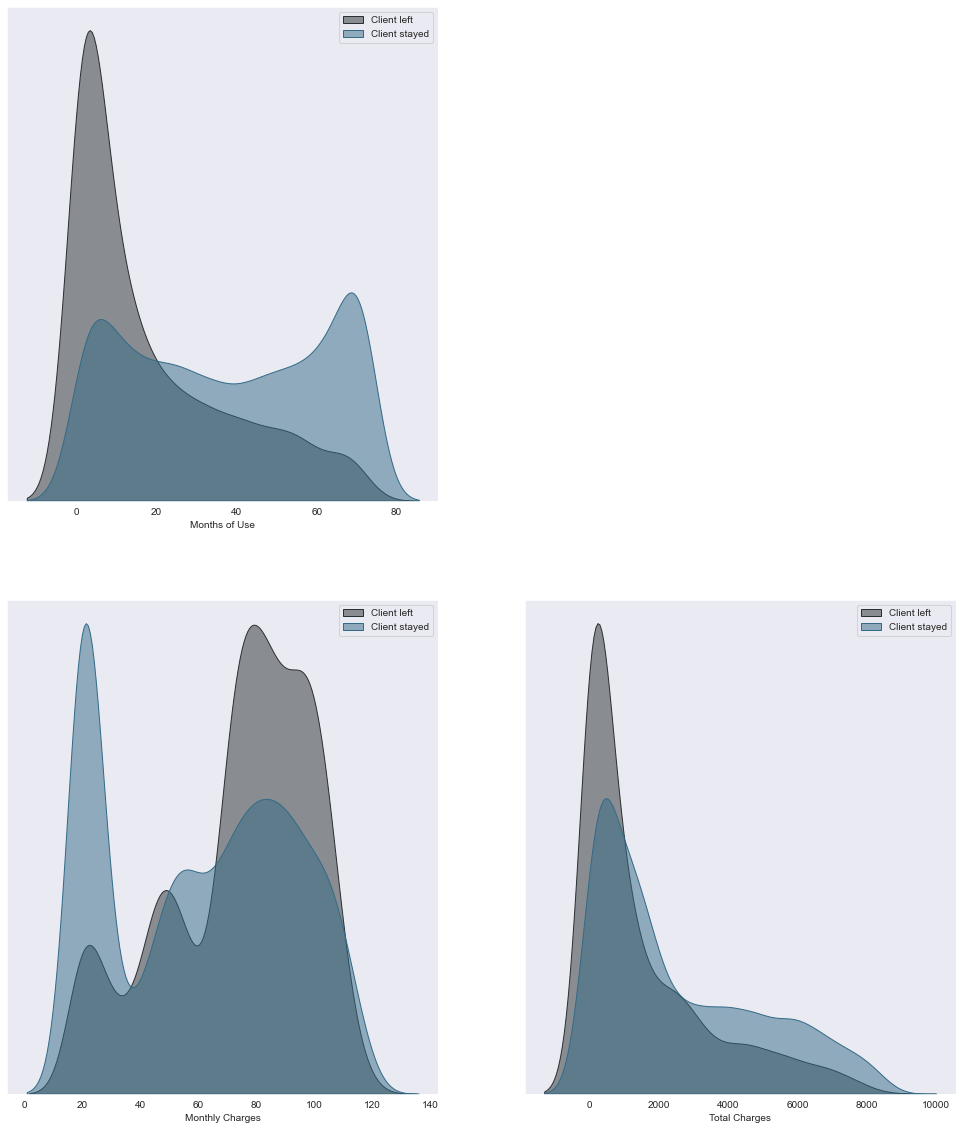

In [25]:
# Tenure 0 -> 1
kdePlots(df_med_one)

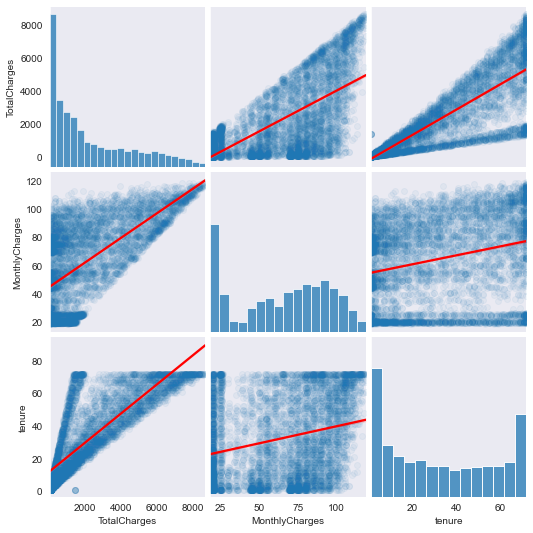

In [26]:
scatterPairWise(df_med_one)

### Data
In this dataset, we have TotalCharges missing values assigned to the median and tenure of 0 assigned to the median.

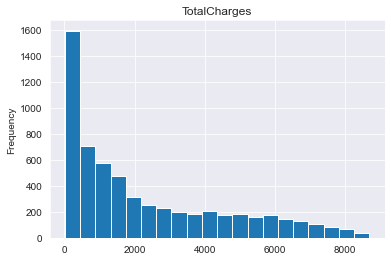

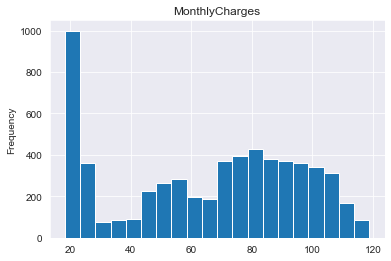

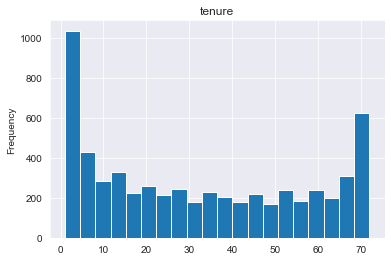

In [27]:
# Tenure 0 -> median
for col in num_columns:
    df_med_med[col].plot(kind='hist', bins=20)
    plt.title(col)
    plt.grid()
    plt.show()

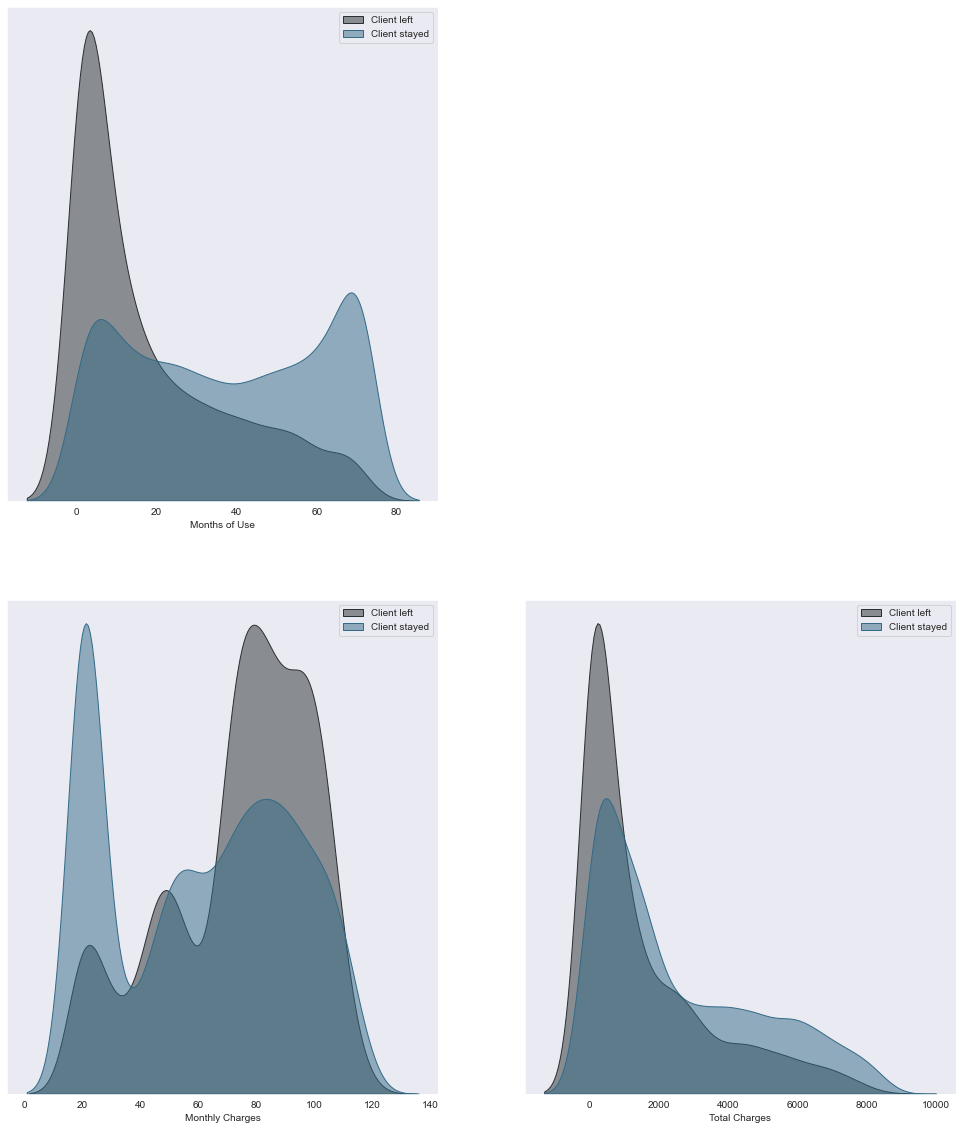

In [28]:
# Tenure 0 -> median
kdePlots(df_med_med)

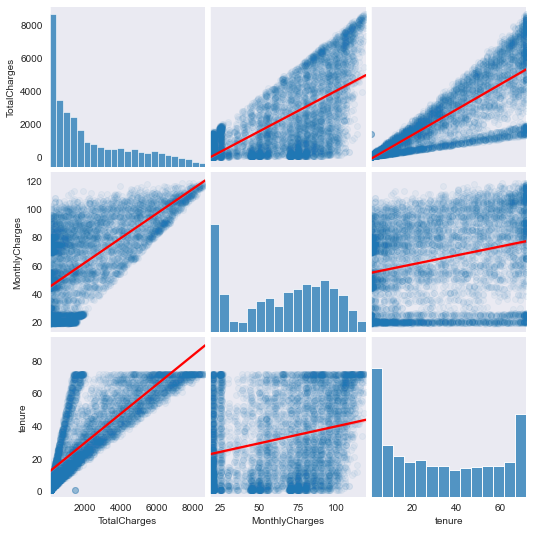

In [29]:
scatterPairWise(df_med_med)

We can see that there is not much change with the distributions when the 10 values are assigned to either zero or median. In this case, we may not see a big difference. However, in datasets with large amount of nulls in a column, the choice one picks here can play a larger role in the model. Let's see how this two play out.

# Affects of Categorical Data on Churn
Here we will look in the distribution of data of customers who churned vs stayed when it comes to categorical data. From this point on, I will only use one dataset for the rest of the analysis. I am going to use the set where we took the median of total charges and the median for tenure when the user had 0. You are free to use which ever set you like but know why you are picking it.

### Spouse

In [30]:
final_df = df_med_med.copy(deep=True)

In [31]:
spouse = final_df.groupby(['Partner', 'Churn']).agg({'Churn': 'count'}).rename(columns={'Churn': 'count'}).reset_index()
spouse.iloc[[0,1], 0] = 'Not married'
spouse.iloc[[2,3], 0] = 'Married'
spouse

,Partner,Churn,count
0,Not married,No,2071
1,Not married,Yes,1011
2,Married,No,2328
3,Married,Yes,576


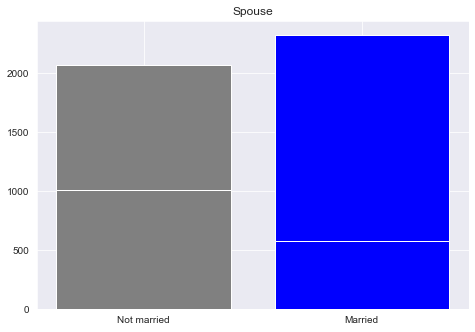

In [32]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(spouse[spouse.Partner == "Not married"]["Partner"], spouse[spouse.Partner == "Not married"]["count"], color="grey")
ax.bar(spouse[spouse.Partner == "Married"]["Partner"], spouse[spouse.Partner == "Married"]["count"], color="b")
plt.title("Spouse")
ax.grid()
plt.show()

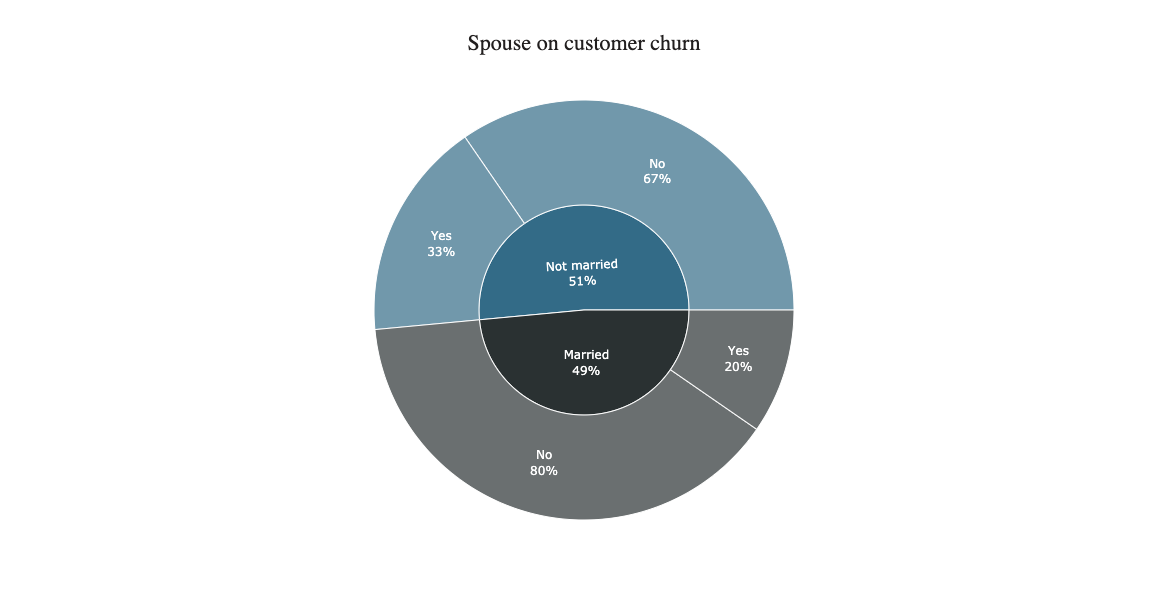

In [33]:
fig = px.sunburst(spouse, 
                  path=['Partner', 'Churn'], 
                  values='count', 
                  color='Partner', 
                  title='Spouse on customer churn',
                  color_discrete_map={'Not married': '#336B87', 'Married': '#2A3132'},
                  width=600, 
                  height=600
                 )

fig.update_layout(plot_bgcolor='white', 
                  title_font_family='Calibri Black', 
                  title_font_color='#221f1f', 
                  title_font_size=22, 
                  title_x=0.5)
fig.update_traces(textinfo='label + percent parent')                 
fig.show()

### Senior Citizen
Senior citizens are those with a pension and/or retired and over an age based on the country.

In [34]:
senior = final_df.groupby(['SeniorCitizen', 'Churn']).agg({'Churn': 'count'}).rename(columns={'Churn': 'count'}).reset_index()
senior.iloc[[0,1], 0] = 'Not pensioner'
senior.iloc[[2,3], 0] = 'Pensioner'
senior

,SeniorCitizen,Churn,count
0,Not pensioner,No,3835
1,Not pensioner,Yes,1185
2,Pensioner,No,564
3,Pensioner,Yes,402


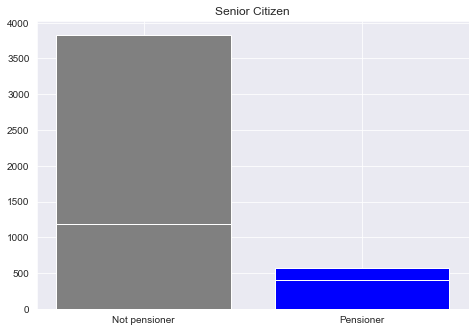

In [35]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(senior[senior.SeniorCitizen == "Not pensioner"]["SeniorCitizen"], 
       senior[senior.SeniorCitizen == "Not pensioner"]["count"], color="grey"
      )
ax.bar(senior[senior.SeniorCitizen == "Pensioner"]["SeniorCitizen"], 
       senior[senior.SeniorCitizen == "Pensioner"]["count"], color="b"
      )
plt.title("Senior Citizen")
ax.grid()
plt.show()

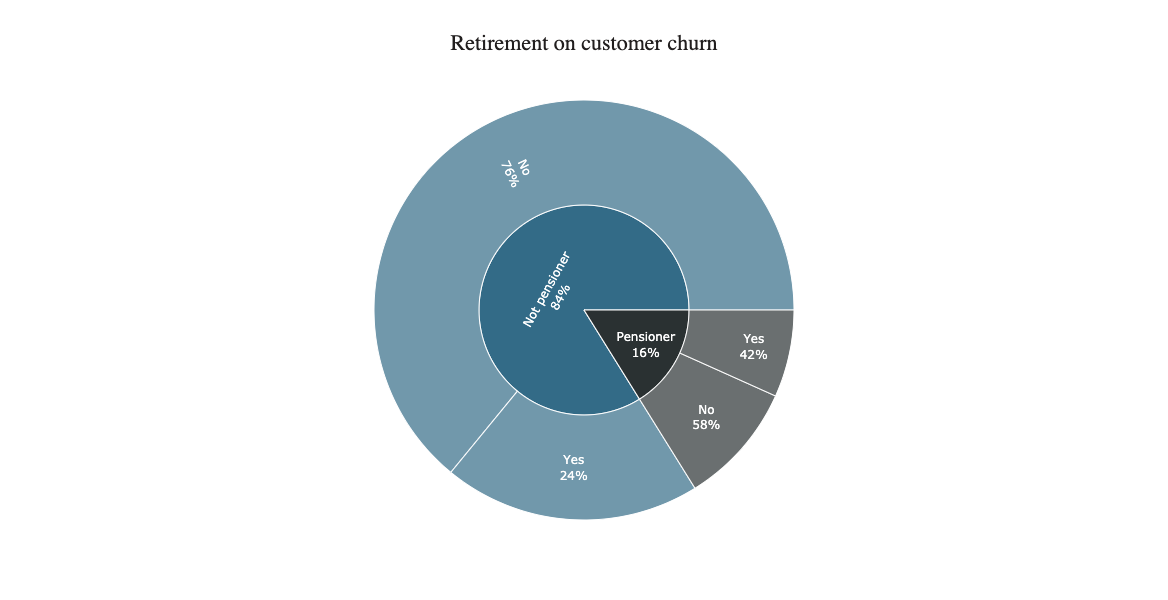

In [36]:
fig = px.sunburst(senior, 
                  path=['SeniorCitizen', 'Churn'], 
                  values='count', 
                  color='SeniorCitizen', 
                  title = 'Retirement on customer churn',
                  color_discrete_map={'Not pensioner': '#336B87', 'Pensioner': '#2A3132'},
                  width=600, 
                  height=600
                 )
fig.update_layout(plot_bgcolor='white', 
                  title_font_family='Calibri Black', 
                  title_font_color='#221f1f', 
                  title_font_size=22, 
                  title_x=0.5
                 )
fig.update_traces(textinfo='label + percent parent')
fig.show()

### Phone Service

In [37]:
phone = final_df.groupby(['PhoneService', 'Churn']).agg({'Churn': 'count'}).rename(columns={'Churn': 'count'}).reset_index()
phone.iloc[[0,1], 0] = 'No phone service'
phone.iloc[[2,3], 0] = 'Yes phone service'
phone

,PhoneService,Churn,count
0,No phone service,No,441
1,No phone service,Yes,149
2,Yes phone service,No,3958
3,Yes phone service,Yes,1438


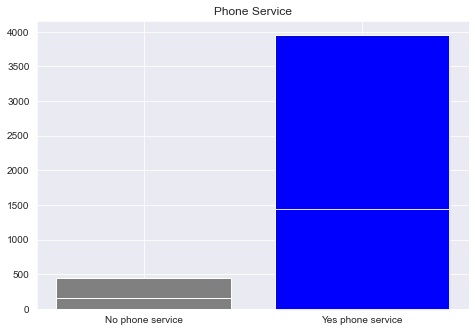

In [38]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(phone[phone.PhoneService == "No phone service"]["PhoneService"], 
       phone[phone.PhoneService == "No phone service"]["count"], color="grey"
      )
ax.bar(phone[phone.PhoneService == "Yes phone service"]["PhoneService"], 
       phone[phone.PhoneService == "Yes phone service"]["count"], color="b"
      )
plt.title("Phone Service")
ax.grid()
plt.show()

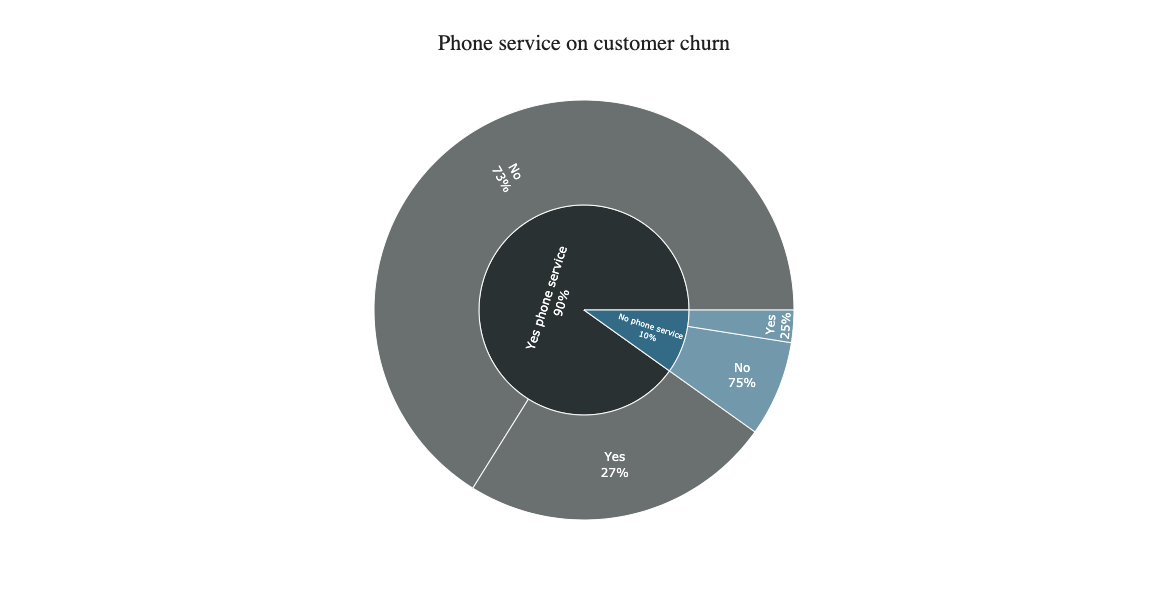

In [39]:
fig = px.sunburst(phone, 
                  path=['PhoneService', 'Churn'], 
                  values='count', 
                  color='PhoneService', 
                  title = 'Phone service on customer churn',
                  color_discrete_map={'No phone service': '#336B87', 'Yes phone service': '#2A3132'},
                  width=600, 
                  height=600
                 )
fig.update_layout(plot_bgcolor='white', 
                  title_font_family='Calibri Black', 
                  title_font_color='#221f1f', 
                  title_font_size=22, 
                  title_x=0.5
                 )
fig.update_traces(textinfo='label + percent parent')
fig.show()

### Internet Service

In [40]:
internet = final_df.groupby(['InternetService', 'Churn']).agg({'Churn': 'count'}).rename(columns={'Churn': 'count'}).reset_index()
internet.iloc[[4,5], 0] = 'No internet'
internet

,InternetService,Churn,count
0,DSL,No,1671
1,DSL,Yes,397
2,Fiber optic,No,1536
3,Fiber optic,Yes,1091
4,No internet,No,1192
5,No internet,Yes,99


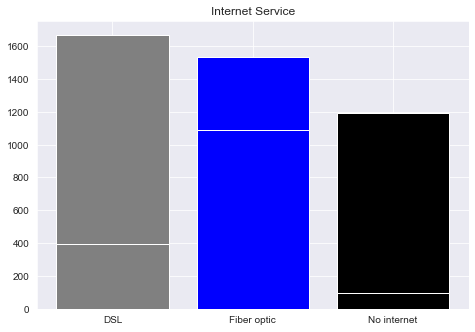

In [41]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(internet[internet.InternetService == "DSL"]["InternetService"], 
       internet[internet.InternetService == "DSL"]["count"], color="grey"
      )
ax.bar(internet[internet.InternetService == "Fiber optic"]["InternetService"], 
       internet[internet.InternetService == "Fiber optic"]["count"], color="b"
      )
ax.bar(internet[internet.InternetService == "No internet"]["InternetService"], 
       internet[internet.InternetService == "No internet"]["count"], color="black"
      )
plt.title("Internet Service")
ax.grid()
plt.show()

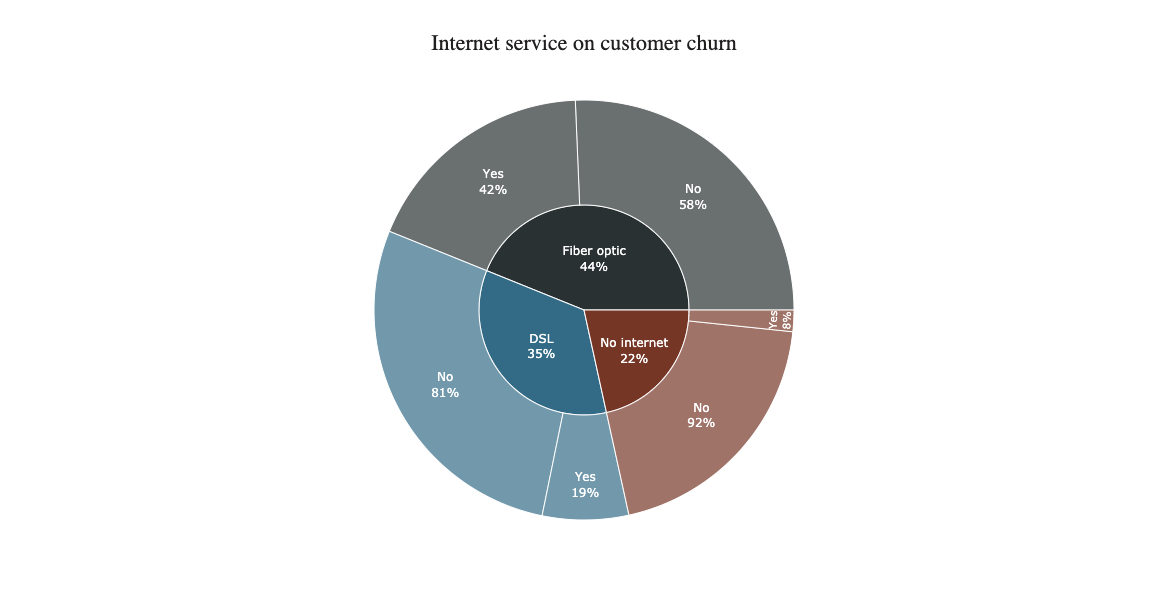

In [42]:
fig = px.sunburst(internet, 
                  path=['InternetService', 'Churn'], 
                  values='count', 
                  color='InternetService', 
                  title = 'Internet service on customer churn',
                  color_discrete_map={'DSL': '#336B87', 'Fiber optic': '#2A3132', 'No internet': '#763626'},
                  width=600, 
                  height=600
                 )
fig.update_layout(plot_bgcolor='white', 
                  title_font_family='Calibri Black', 
                  title_font_color='#221f1f', 
                  title_font_size=22, 
                  title_x=0.5
                 )
fig.update_traces(textinfo='label + percent parent')
fig.show()

### Online Security

In [43]:
i_sec = final_df.groupby(['OnlineSecurity', 'Churn']).agg({'Churn': 'count'}).rename(columns={'Churn': 'count'}).reset_index()

i_sec

,OnlineSecurity,Churn,count
0,No,No,1740
1,No,Yes,1242
2,No internet service,No,1192
3,No internet service,Yes,99
4,Yes,No,1467
5,Yes,Yes,246


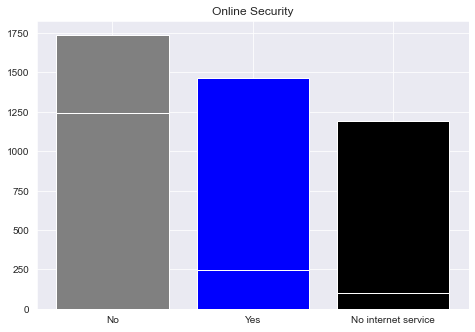

In [44]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(i_sec[i_sec.OnlineSecurity == "No"]["OnlineSecurity"], 
       i_sec[i_sec.OnlineSecurity == "No"]["count"], color="grey"
      )
ax.bar(i_sec[i_sec.OnlineSecurity == "Yes"]["OnlineSecurity"], 
       i_sec[i_sec.OnlineSecurity == "Yes"]["count"], color="b"
      )
ax.bar(i_sec[i_sec.OnlineSecurity == "No internet service"]["OnlineSecurity"], 
       i_sec[i_sec.OnlineSecurity == "No internet service"]["count"], color="black"
      )
plt.title("Online Security")
ax.grid()
plt.show()

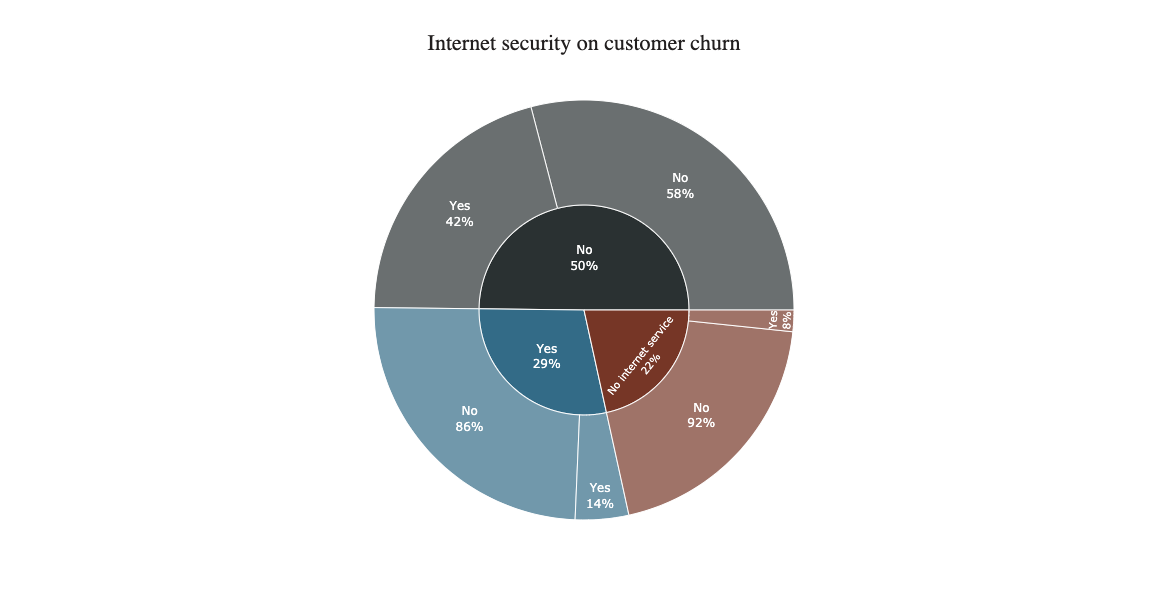

In [45]:
fig = px.sunburst(i_sec, 
                  path=['OnlineSecurity', 'Churn'], 
                  values='count', 
                  color='OnlineSecurity', 
                  title = 'Internet security on customer churn',
                  color_discrete_map={'Yes': '#336B87', 'No': '#2A3132', 'No internet service': '#763626'},
                  width=600, 
                  height=600
                 )
fig.update_layout(plot_bgcolor='white', 
                  title_font_family='Calibri Black', 
                  title_font_color='#221f1f', 
                  title_font_size=22, 
                  title_x=0.5
                 )
fig.update_traces(textinfo='label + percent parent')
fig.show()

### Contract Type

In [46]:
contract = final_df.groupby(['Contract', 'Churn']).agg({'Churn': 'count'}).rename(columns={'Churn': 'count'}).reset_index()

contract

,Contract,Churn,count
0,Month-to-month,No,1871
1,Month-to-month,Yes,1398
2,One year,No,1128
3,One year,Yes,148
4,Two year,No,1400
5,Two year,Yes,41


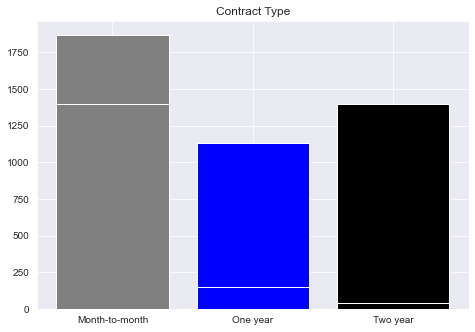

In [47]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(contract[contract.Contract == "Month-to-month"]["Contract"], 
       contract[contract.Contract == "Month-to-month"]["count"], color="grey"
      )
ax.bar(contract[contract.Contract == "One year"]["Contract"], 
       contract[contract.Contract == "One year"]["count"], color="b"
      )
ax.bar(contract[contract.Contract == "Two year"]["Contract"], 
       contract[contract.Contract == "Two year"]["count"], color="black"
      )
plt.title("Contract Type")
ax.grid()
plt.show()

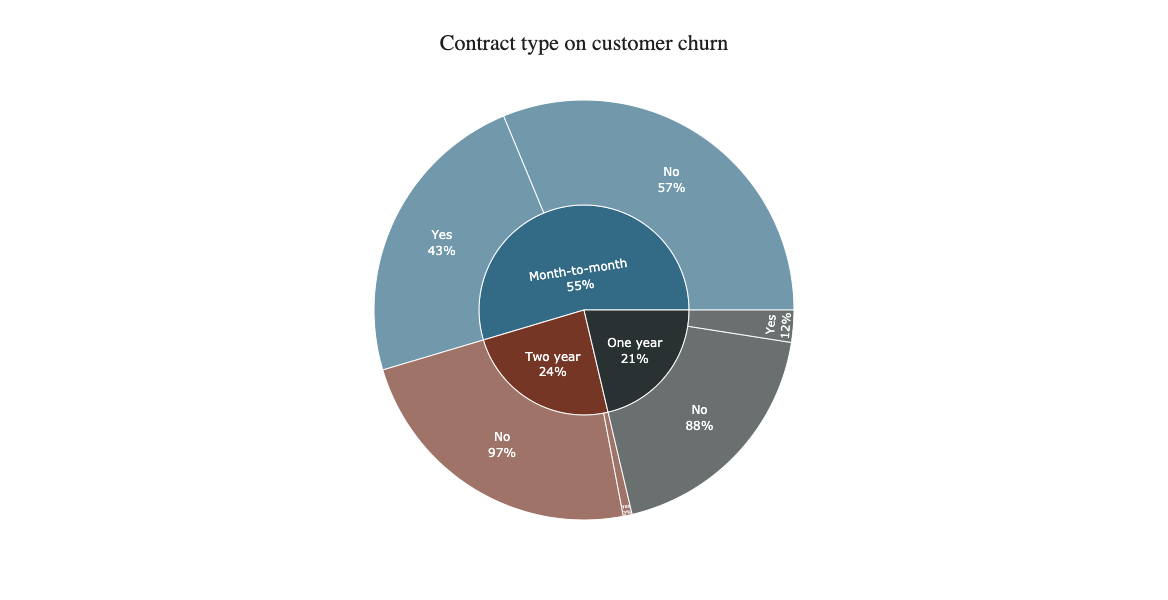

In [48]:
fig = px.sunburst(contract, 
                  path=['Contract', 'Churn'], 
                  values='count', 
                  color='Contract', 
                  title = 'Contract type on customer churn',
                  color_discrete_map={'Month-to-month': '#336B87', 'One year': '#2A3132', 'Two year': '#763626'},
                  width=600, 
                  height=600
                 )
fig.update_layout(plot_bgcolor='white', 
                  title_font_family='Calibri Black', 
                  title_font_color='#221f1f', 
                  title_font_size=22, 
                  title_x=0.5
                 )
fig.update_traces(textinfo='label + percent parent')
fig.show()

### Method of Payment

In [49]:
payment = final_df.groupby(['PaymentMethod', 'Churn']).agg({'Churn': 'count'}).rename(columns={'Churn': 'count'}).reset_index()

payment

,PaymentMethod,Churn,count
0,Bank transfer (automatic),No,1084
1,Bank transfer (automatic),Yes,224
2,Credit card (automatic),No,1105
3,Credit card (automatic),Yes,198
4,Electronic check,No,1104
5,Electronic check,Yes,902
6,Mailed check,No,1106
7,Mailed check,Yes,263


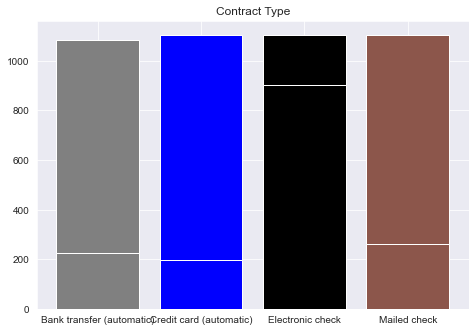

In [50]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(payment[payment.PaymentMethod == "Bank transfer (automatic)"]["PaymentMethod"], 
       payment[payment.PaymentMethod == "Bank transfer (automatic)"]["count"], color="grey"
      )
ax.bar(payment[payment.PaymentMethod == "Credit card (automatic)"]["PaymentMethod"], 
       payment[payment.PaymentMethod == "Credit card (automatic)"]["count"], color="b"
      )
ax.bar(payment[payment.PaymentMethod == "Electronic check"]["PaymentMethod"], 
       payment[payment.PaymentMethod == "Electronic check"]["count"], color="black"
      )
ax.bar(payment[payment.PaymentMethod == "Mailed check"]["PaymentMethod"], 
       payment[payment.PaymentMethod == "Mailed check"]["count"], color="tab:brown"
      )
plt.title("Contract Type")
ax.grid()
plt.show()

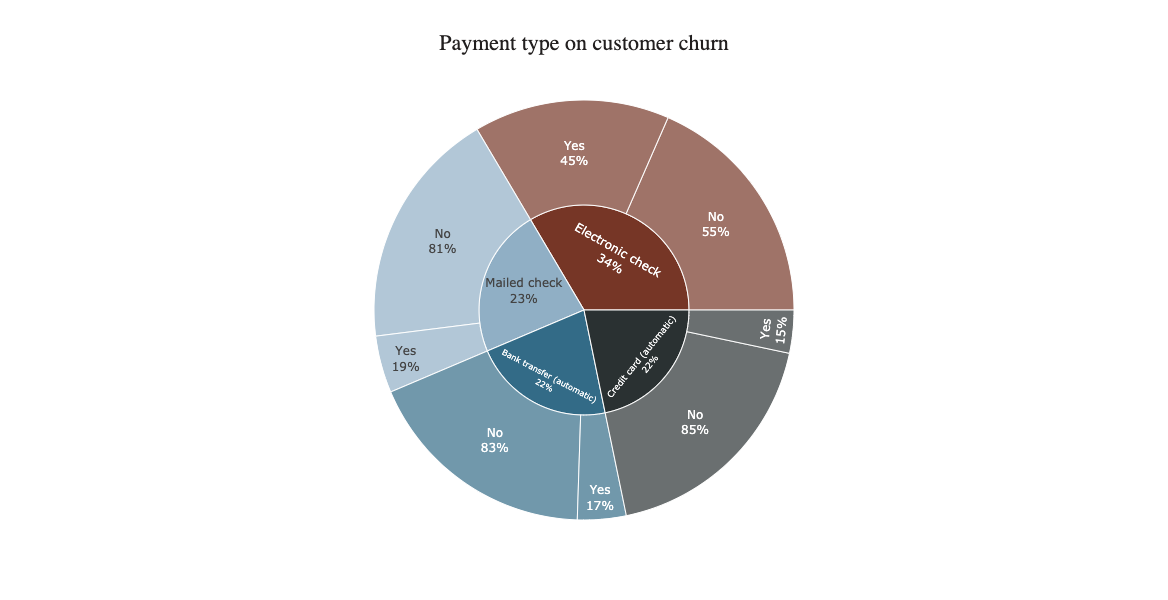

In [51]:
fig = px.sunburst(payment, 
                  path=['PaymentMethod', 'Churn'], 
                  values='count', 
                  color='PaymentMethod', 
                  title = 'Payment type on customer churn',
                  color_discrete_map={'Bank transfer (automatic)': '#336B87', 'Credit card (automatic)': '#2A3132', 
                                      'Electronic check': '#763626', 'Mailed check': '#90AFC5'},
                  width=600, 
                  height=600
                 )
fig.update_layout(plot_bgcolor='white', 
                  title_font_family='Calibri Black', 
                  title_font_color='#221f1f', 
                  title_font_size=22, 
                  title_x=0.5
                 )
fig.update_traces(textinfo='label + percent parent')
fig.show()

There are a few more categorical variables to explore. However, those will be left as an exercise to the reader if they are interested in seeing the results.

# Preprocessing Data

In [52]:
X = final_df.drop('Churn', axis=1)
y = final_df.Churn.map({"No": 0, "Yes": 1})

## Encode Categorical Lables
We need to encode our categorical labels to numeric.

In [53]:
def labelEncoder(df: pd.DataFrame, cat_cols: List[str]) -> pd.DataFrame:
    for i in cat_cols:
        df[i] = LabelEncoder().fit_transform(df[i])
    return df

### Scaling
Here we will use a the StandardScaler. The selection of your scaler is important to results. If you do not have semi-normal data, you should not be using the StandardScaler. We only need to scale the numerical data and not the encoded data.

In notebook by Dimtry, he scales the data before splitting it into testing and training datasets. This is not correct. Split your data and then scale it. When you scale the whole dataset and then split it, you have introduced information into the testing set from the training set. [Here](https://stackoverflow.com/a/49444783/2213669) is an answer on StackOverflow about when to scale for a more detailed answer.

In [54]:
X = labelEncoder(X, [c for c in cat_columns if c != "Churn"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=25)

In [55]:
sc = StandardScaler()
X_train[num_columns] = sc.fit_transform(X_train[num_columns])
X_test[num_columns] = sc.transform(X_test[num_columns])

<ipython-input-55-e0d439af1292>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/dustinsmith/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-55-e0d439af1292>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [56]:
X_train

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
4392,0,0,1,1,1.028391,1,0,0,2,2,0,0,0,0,1,0,2,-0.357673,0.363006
4196,1,0,0,0,1.641631,0,1,0,2,2,2,2,2,2,2,1,0,0.042866,1.142206
1199,1,0,1,1,0.456033,1,0,2,1,1,1,1,1,1,1,1,3,-1.491427,-0.648163
5171,0,1,1,0,0.210736,1,0,2,1,1,1,1,1,1,1,0,3,-1.478186,-0.669681
994,1,0,0,0,-1.261042,1,0,0,0,0,0,0,0,0,0,1,2,-0.706902,-0.973864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,0,1,1,0,1.396335,1,2,0,0,2,2,0,2,2,2,1,0,0.539400,1.345461
2934,1,0,1,0,1.437218,1,2,1,2,2,2,0,2,2,1,0,1,1.510954,2.263607
2191,0,0,1,1,1.069273,1,2,1,2,2,0,0,0,2,0,1,0,0.964765,1.421185
318,0,0,1,1,0.864860,0,1,0,2,2,2,0,0,2,0,1,0,-0.514909,0.115271


# Models
First, we will create the sklearn, XGBoost, and LightGDM models. Additionally, we will look at the difference of using SMOTE to oversample the customers who did not churn and leaving the data as is. We have an imbalanced data sets where we have 3 users who did not churn for every one user who did